In [1]:
from voxel import *

# Gaussians

## Numerical Approximations

In [2]:
def get_2D_gaussian(mus, sigma, K, A):
    def s(v):
        x = v[0]
        y = v[1]
        
        f = 0.
        for kx in np.arange(-K,K+1):
            for ky in np.arange(-K,K+1):
                for mu in mus:
                    Ak = A.dot([kx,ky])
                    mx = Ak[0]+mu[0]
                    my = Ak[1]+mu[1]
                    f += np.exp(-((x - mx)**2 + (y - my)**2) / (2*sigma**2))
            
        return f / (2*np.pi * sigma**2)
    
    return s

### Centered in Unit Cell

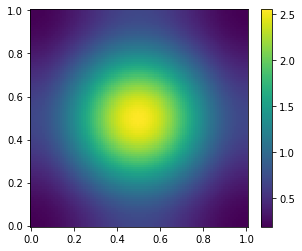

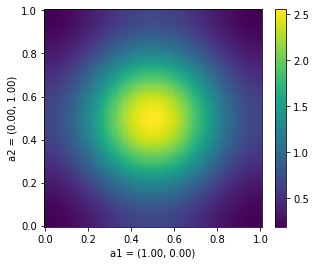

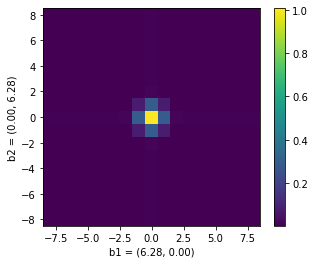

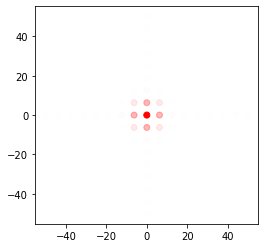

In [3]:
A = np.eye(2)
gauss = get_2D_gaussian(np.array([[0.5,0.5]]), 0.25, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
plot_2D_bravais_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice(gauss, A, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

### Corner of Unit Cell

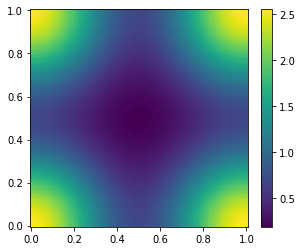

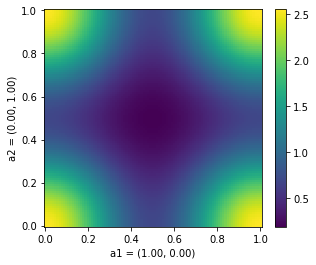

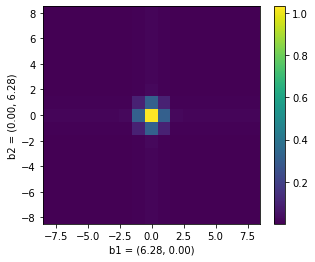

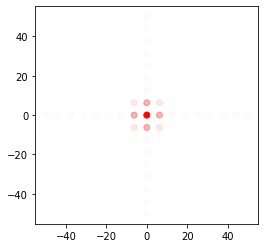

In [4]:
A = np.eye(2)
gauss = get_2D_gaussian(np.array([[0.,0.]]), 0.25, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
plot_2D_bravais_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice(gauss, A, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

### Different Basis

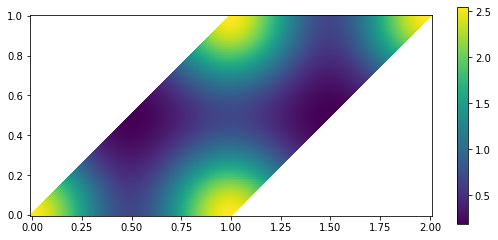

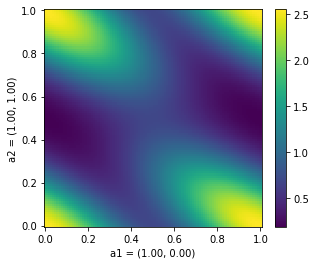

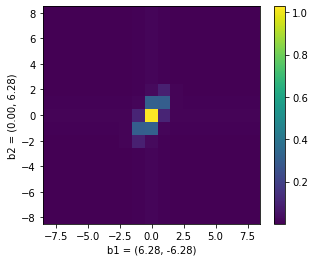

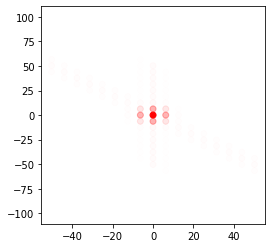

In [5]:
A = np.array([
    [1., 1.],
    [0., 1.]
])
gauss = get_2D_gaussian(np.array([[0.,0.]]), 0.25, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
plot_2D_bravais_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice(gauss, A, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

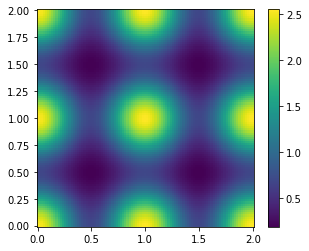

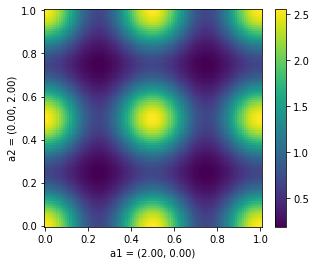

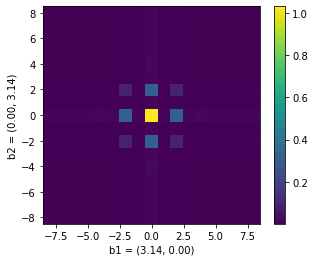

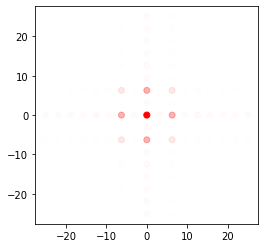

In [6]:
A = np.eye(2)*2
gauss = get_2D_gaussian(np.array([[0.,0.]]), 0.25, 3, np.eye(2))
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
plot_2D_bravais_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice(gauss, A, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

### Custom Points

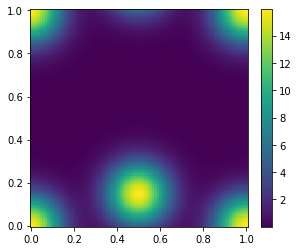

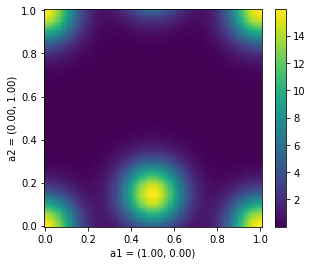

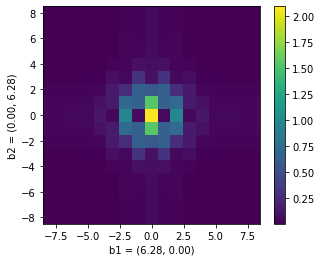

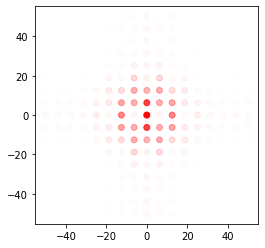

In [7]:
A = np.eye(2)
gauss = get_2D_gaussian(np.array([[0.,0.], [0.5,0.15]]), 0.1, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
plot_2D_bravais_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice(gauss, A, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

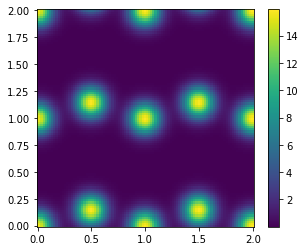

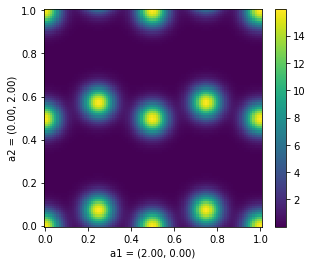

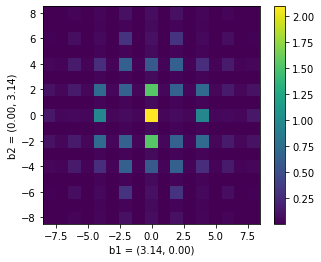

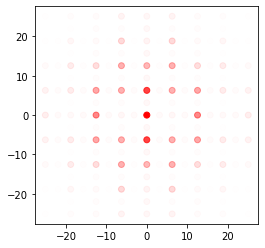

In [8]:
A = np.eye(2)*2
gauss = get_2D_gaussian(np.array([[0.,0.], [0.5,0.15]]), 0.1, 3, np.eye(2))
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
plot_2D_bravais_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice(gauss, A, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

## Theoretical Fourier Transform

In [9]:
def reciprocal_lattice_gaussian(A, mus, sigma, g0=-16, g1=16, d=2):
    B = 2*np.pi * np.linalg.inv(A).T
    
    mi = np.arange(g0,g1+1)
    m = len(mi)
    
    if d == 2:
        m1, m2 = np.meshgrid(mi, mi)
        M = np.vstack((m1.reshape(1,-1), m2.reshape(1,-1))) # (2,m*m)

    G = B.dot(M) # (d,m*m)
    
    GG = np.linalg.norm(G, axis=0) ** 2 # (m*m,)
    
    expGG = np.exp(-sigma**2 / 2 * GG) # (m*m,)

    muG = mus.dot(G) # (n,d) * (d, m*m) = (n, m*m)
    
    expmuG = np.exp(-1j * muG) # (n, m*m)
    
    SG = 1/np.linalg.det(A) * expGG * np.sum(expmuG, axis=0) #(m*m,)

    SG = SG.reshape(m,m)
    
    return (B, mi, SG)

### Centered in Unit Cell

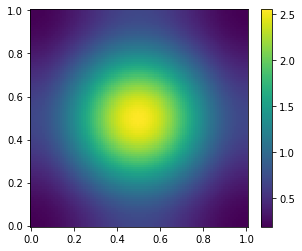

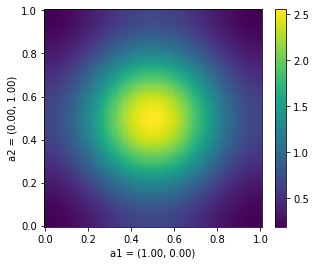

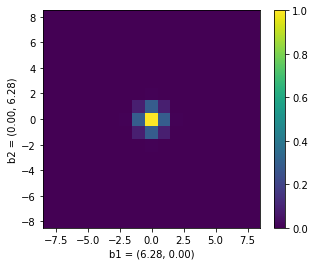

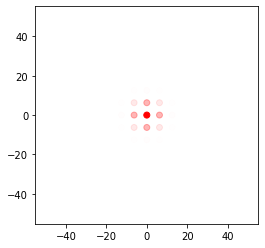

In [10]:
A = np.eye(2)
sigma = 0.25
mus = np.array([[0.5,0.5]])
gauss = get_2D_gaussian(mus, sigma, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
plot_2D_bravais_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice_gaussian(A, mus, sigma, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

### Corner in Unit Sphere and Different Basis

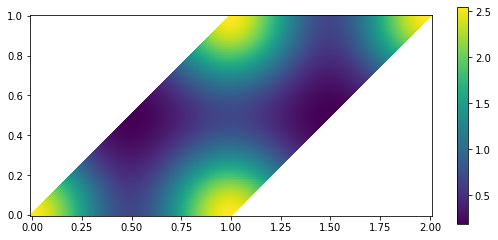

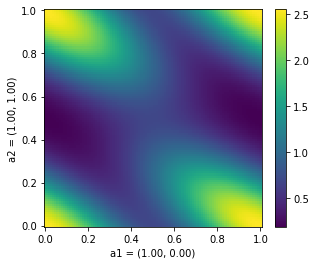

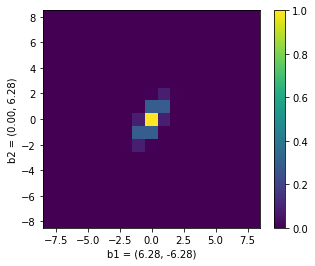

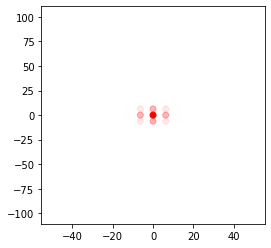

In [11]:
A = np.array([
    [1., 1.],
    [0., 1.]
])
sigma = 0.25
mus = np.array([[0.,0.]])
gauss = get_2D_gaussian(mus, sigma, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
plot_2D_bravais_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice_gaussian(A, mus, sigma, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

### Custom Points

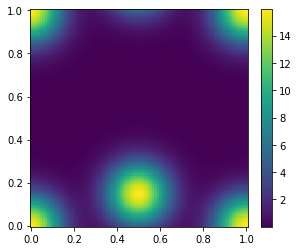

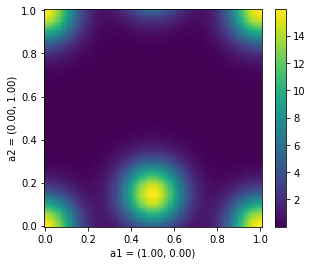

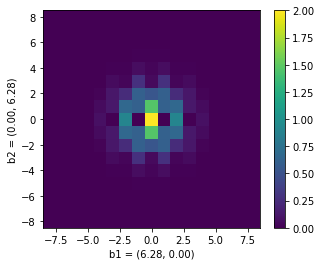

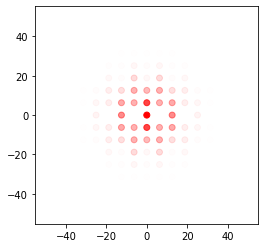

In [12]:
A = np.eye(2)
mus = np.array([[0.,0.], [0.5,0.15]])
sigma = 0.1
gauss = get_2D_gaussian(mus, sigma, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
plot_2D_bravais_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice_gaussian(A, mus, sigma, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

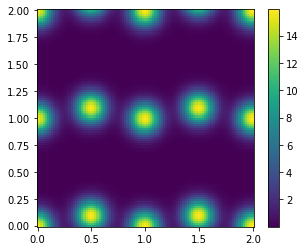

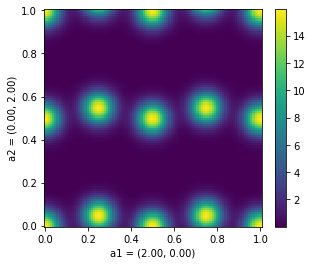

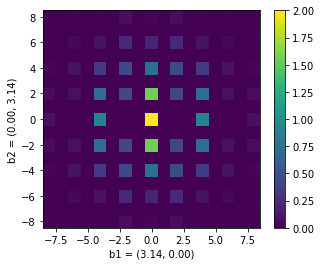

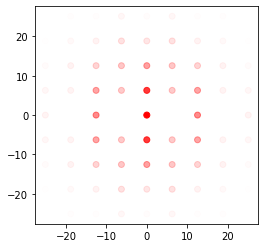

In [13]:
A = np.eye(2)*2
mus = np.array([
    [0., 0.],
    [0.5, 0.1],
    [0., 1.],
    [1., 0.],
    [1.5, 0.1],
    [0.5, 1.1],
    [1.5, 1.1],
    [1.,1.]
])
sigma = 0.1
gauss = get_2D_gaussian(mus, sigma, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
plot_2D_bravais_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice_gaussian(A, mus, sigma, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)